#### Bag of Words Approaches:
- In this notebook I use bag of words (BoW) type of text vectorization. 
- Evaluation metrics are: AUC and F1 score. 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from scipy.sparse import csr_matrix
from time import time
import re
import string
import tensorflow as tf
import pickle
import operator
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords


# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score

# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils


[nltk_data] Downloading package punkt to /home/elena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/elena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
df_train = pd.read_pickle('train_prepared_a.pkl')
print(len(df_train))
df_valid = pd.read_pickle('valid_prepared_a.pkl')
print(len(df_valid))
df_test = pd.read_pickle('test_prepared_a.pkl')
print(len(df_test))

4198
7667
7667


####  CountVectorizer from scikit-learn package simply counts how many times each word occurs in the note.

In [48]:
vocabulary_size = 20000

In [49]:
vect = CountVectorizer(max_features = 50000)
vect.fit(df_train.TEXT.values)
X_train_tf = vect.transform(df_train.TEXT.values)
X_train_tf.shape

(4198, 29079)

#### Finding most frequent words to use them as Stop-Words:¶

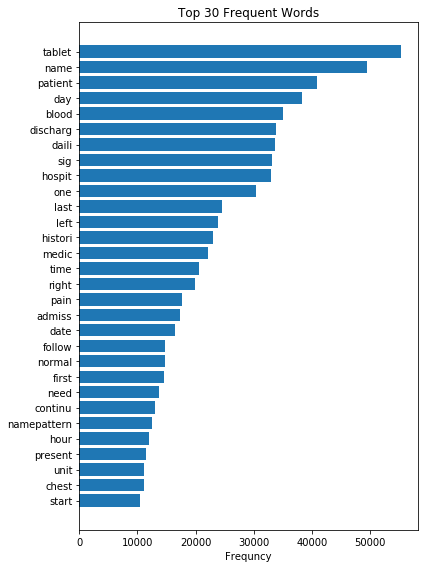

In [50]:
sum_words = X_train_tf.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq_plot = words_freq[:30]
values = [value[0] for value in words_freq_plot]
freq = [value[1] for value in words_freq_plot]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,8), sharex=True)
plt.barh(range(len(values)),freq, align = 'center')
plt.yticks(range(len(values)),values)
plt.title("Top 30 Frequent Words")
plt.gca().invert_yaxis()
plt.xlabel('Frequncy')
plt.tight_layout()
plt.show()

#### We can see the most frequent words. Now we can make our own stop words:

In [51]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also']

## Bag-of-Words 

### Before train the models let us select the parameter of the vectorizer, number of features. 

In [52]:
from sklearn import preprocessing
from sklearn import svm

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

# Response:

y_train_labels = df_train.OUTPUT_LABEL
y_valid_labels = df_valid.OUTPUT_LABEL
y_test_labels = df_test.OUTPUT_LABEL


le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
y_train=np.array(le.transform(y_train_labels))


le.fit(y_valid_labels)
y_valid=np.array(le.transform(y_valid_labels))

le.fit(y_test_labels)
y_test=np.array(le.transform(y_test_labels))

print(y_train[:10])
print(y_train.shape)
print(X_train_tf.shape)
print(X_test_tf.shape)

[0 1 0 0 1 0 0 1 1 0]
(4198,)
(4198, 29079)
(7667, 29079)


### We try 8 options and select the best AUC score. 

In [53]:
names = ['3000', '5000', '10000', '12000',
        '15000', '20000', '25000', '50000']

vectorizers = [
    CountVectorizer(max_features = 3000, stop_words = my_stop_words),
    CountVectorizer(max_features = 5000, stop_words = my_stop_words),
    CountVectorizer(max_features = 10000, stop_words = my_stop_words),
    CountVectorizer(max_features = 12000, stop_words = my_stop_words),
    CountVectorizer(max_features = 15000, stop_words = my_stop_words),
    CountVectorizer(max_features = 20000, stop_words = my_stop_words),
    CountVectorizer(max_features = 25000, stop_words = my_stop_words),
    CountVectorizer(max_features = 50000, stop_words = my_stop_words)
]

auc_train = []
auc_valid = []
F1_train = []
F1_valid = []

clf = LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42, n_jobs=-1)

for name, vect in zip(names, vectorizers):
    vect.fit(df_train.TEXT.values)
    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    clf.fit(X_train_tf, y_train)
    
    y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
    auc_tr = metrics.auc(fpr,tpr)
    auc_train.append(auc_tr)
    
    y_train_preds = clf.predict(X_train_tf)
    f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
    F1_train.append(f1_tr)
    
    y_valid_pred = clf.predict_proba(X_valid_tf)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_pred)
    auc_val = metrics.auc(fpr,tpr)
    auc_valid.append(auc_val)
    
    y_valid_pred = clf.predict(X_valid_tf)
    f1_val = metrics.f1_score(y_valid, y_valid_pred, average='macro')
    F1_valid.append(f1_val)
    
    print(name, 'AUC train: ', auc_tr)
    print(name, 'F1 train: ', f1_tr)
    print(name, 'AUC valid: ', auc_val)
    print(name, 'F1 valid : ', f1_val)
    print()
    
d = dict(zip(names, auc_valid))

print(max(d.items(), key=operator.itemgetter(1))[0])

#save the best number of features 
bestF = int(max(d.items(), key=operator.itemgetter(1))[0])

3000 AUC train:  0.7411525168749109
3000 F1 train:  0.6715299586341796
3000 AUC valid:  0.6938545095577664
3000 F1 valid :  0.5096939633151114

5000 AUC train:  0.7437647546950032
5000 F1 train:  0.6741513149691218
5000 AUC valid:  0.6940378916713501
5000 F1 valid :  0.5093238322794714

10000 AUC train:  0.7449872338764278
10000 F1 train:  0.6746501963058396
10000 AUC valid:  0.6941266936235332
10000 F1 valid :  0.5098577760793

12000 AUC train:  0.7450846055007933
12000 F1 train:  0.6746501963058396
12000 AUC valid:  0.6941187866003936
12000 F1 valid :  0.5098577760793

15000 AUC train:  0.7451885593561761
15000 F1 train:  0.6746501963058396
15000 AUC valid:  0.694126085390984
15000 F1 valid :  0.5098577760793

20000 AUC train:  0.7452700428367055
20000 F1 train:  0.6746501963058396
20000 AUC valid:  0.6941349047629474
20000 F1 valid :  0.5098577760793

25000 AUC train:  0.7453122599046121
25000 F1 train:  0.6746501963058396
25000 AUC valid:  0.6941355129954966
25000 F1 valid :  0.509

### Vectorize the text with the best number of features. 

In [54]:
vect = CountVectorizer(max_features = bestF,  
                       stop_words = my_stop_words)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=25000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [55]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)
print(X_train_tf.shape)
print(X_valid_tf.shape)
print(X_test_tf.shape)

(4198, 25000)
(7667, 25000)
(7667, 25000)


In [56]:
Model = []
AUC_train = []
F1_train = []
AUC_valid = []
F1_valid = []

### Logistic Regression for BoW

### Let us do some experiments with Logistic Regression classifier and select the model with the best parameters and performance. We start with a baseline model. 

In [57]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', n_jobs=-1, random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [58]:
y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
auc_tr = metrics.auc(fpr,tpr)
print(auc_tr)
    
y_train_preds = clf.predict(X_train_tf)
f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
print(f1_tr)

y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc_valid = metrics.auc(fpr,tpr)
print(auc_valid)

y_valid_preds = clf.predict(X_valid_tf)
f1_valid = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f1_valid)

0.7453122599046121
0.6746501963058396
0.6941355129954966
0.5098577760793


In [59]:
Model.append('Baseline LogReg')
AUC_train.append(auc_tr)
F1_train.append(f1_tr)
AUC_valid.append(auc_valid)
F1_valid.append(f1_valid)

### The second LogReg model is trained with 10-fold cross-validation. 

In [60]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, penalty = 'l2', n_jobs=-1, random_state=42)
clf.fit(X_train_tf, y_train)
print(clf.get_params())

{'Cs': 10, 'class_weight': None, 'cv': 10, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [61]:
y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
auc_tr = metrics.auc(fpr,tpr)
print(auc_tr)
    
y_train_preds = clf.predict(X_train_tf)
f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
print(f1_tr)

y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc_valid = metrics.auc(fpr,tpr)
print(auc_valid)

y_valid_preds = clf.predict(X_valid_tf)
f1_valid = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f1_valid)

0.8476273667376262
0.7560502959531283
0.7002902181608507
0.5082553203243952


In [62]:
Model.append('Cross Validation LogReg')
AUC_train.append(auc_tr)
F1_train.append(f1_tr)
AUC_valid.append(auc_valid)
F1_valid.append(f1_valid)

### The third model is trained with the parameters chosen after grid-search over hyperparameters, here C, solver and penalty. 

In [63]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), 
      "penalty":["l1","l2", 'none'], 
     'solver': ['liblinear', 'lbfgs']} 

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10, n_jobs=-1, verbose=True)
logreg_cv.fit(X_train_tf,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.4min finished


tuned hyperparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.6507961131946811


In [64]:
#save the best parameters to pass them to the model 
bestC = logreg_cv.best_params_['C']
print(bestC)
bestPenalty = logreg_cv.best_params_['penalty']
print(bestPenalty)
bestS = logreg_cv.best_params_['solver']
print(bestS)

0.001
l2
liblinear


In [65]:
clf=LogisticRegression(C = bestC, penalty = bestPenalty, solver = bestS, random_state = 42, n_jobs=-1)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [66]:
y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
auc_tr = metrics.auc(fpr,tpr)
print(auc_tr)
    
y_train_preds = clf.predict(X_train_tf)
f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
print(f1_tr)

y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc_valid = metrics.auc(fpr,tpr)
print(auc_valid)

y_valid_preds = clf.predict(X_valid_tf)
f1_valid = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f1_valid)

0.8625377088070934
0.7800956505606441
0.7005395935060227
0.49081342843765663


In [67]:
Model.append('After grid-search')
AUC_train.append(auc_tr)
F1_train.append(f1_tr)
AUC_valid.append(auc_valid)
F1_valid.append(f1_valid)

### Logistic Regression on n-grams up to 3-grams

In [68]:
vect = CountVectorizer(max_features = 25000,  
                       stop_words = my_stop_words,
                       ngram_range= (1,3))
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()
X_test_Array = X_test_tf.todense()

In [69]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, penalty = 'l2', n_jobs=-1, random_state=42)
clf.fit(X_train_tf, y_train)
print(clf.get_params())

{'Cs': 10, 'class_weight': None, 'cv': 10, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [70]:
y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
auc_tr = metrics.auc(fpr,tpr)
print(auc_tr)
    
y_train_preds = clf.predict(X_train_tf)
f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
print(f1_tr)

y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc_valid = metrics.auc(fpr,tpr)
print(auc_valid)

y_valid_preds = clf.predict(X_valid_tf)
f1_valid = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f1_valid)

0.8971143953165384
0.8118226217567215
0.7002683217890796
0.501867748421849


In [71]:
Model.append('LogReg N-Grams')
AUC_train.append(auc_tr)
F1_train.append(f1_tr)
AUC_valid.append(auc_valid)
F1_valid.append(f1_valid)

In [72]:
results = pd.DataFrame({'Model': Model, 'AUC train': AUC_train, 
                       'AUC validation': AUC_valid,
                       'F1 train': F1_train, 'F1 validation': F1_valid})
results

,Model,AUC train,AUC validation,F1 train,F1 validation
0,Baseline LogReg,0.745312,0.694136,0.674650,0.509858
1,Cross Validation LogReg,0.847627,0.700290,0.756050,0.508255
2,After grid-search,0.862538,0.700540,0.780096,0.490813
3,LogReg N-Grams,0.897114,0.700268,0.811823,0.501868


In [73]:
results.to_csv('LogReg_training_results.csv', sep='\t', index=False)

### After the experiments are done, we can see that the best result is on the model after grid-search, but it tends to overfitting more than others and if we pay attention to F1 score, it is the worst. The difference in AUC score is not significant, it is 0.003. In my opinion, the best model is Cross Validation, which performs well both on AUC and F1. 

In [74]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, penalty = 'l2', n_jobs=-1, random_state=42)
clf.fit(X_train_tf, y_train)
print(clf.get_params())

{'Cs': 10, 'class_weight': None, 'cv': 10, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [75]:
training = []
validation = []
test = []
metric = []

In [76]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print('TRAINING')
y_train_pred = clf.predict_proba(X_train_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_train_pred)
auc_tr = metrics.auc(fpr,tpr)
print('AUC ', auc_tr)
    
y_train_preds = clf.predict(X_train_tf)
f1_tr = metrics.f1_score(y_train, y_train_preds, average='macro')
prec_tr = precision_score(y_train, y_train_preds, average='macro') 
recall_tr = recall_score(y_train, y_train_preds, average='macro')
accuracy_tr = accuracy_score(y_train, y_train_preds)
print('F1 ', f1_tr)
print('Precision ', prec_tr)
print('Recall ', recall_tr)
print('Accuracy ', accuracy_tr)
print()
print('VALIDATION')
y_valid_pred = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_pred)
auc_valid = metrics.auc(fpr,tpr)
print('AUC ', auc_valid)

y_valid_preds = clf.predict(X_valid_tf)
f1_valid = metrics.f1_score(y_valid, y_valid_preds, average='macro')
prec_val = precision_score(y_valid, y_valid_preds, average='macro') 
recall_val = recall_score(y_valid, y_valid_preds, average='macro')
accuracy_val = accuracy_score(y_valid, y_valid_preds)
print('F1 ', f1_valid)
print('Precision ', prec_val)
print('Recall ', recall_val)
print('Accuracy ', accuracy_val)
print()
print('TEST')
y_test_pred = clf.predict_proba(X_test_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), y_test_pred)
auc_test = metrics.auc(fpr,tpr)
print('AUC ', auc_test)
y_test_preds = clf.predict(X_test_tf)
f1_test = metrics.f1_score(y_test, y_test_preds, average='macro')
prec_test = precision_score(y_test, y_test_preds, average='macro') 
recall_test = recall_score(y_test, y_test_preds, average='macro')
accuracy_test = accuracy_score(y_test, y_test_preds)
print('F1 ', f1_test)
print('Precision ', prec_test)
print('Recall ', recall_test)
print('Accuracy ', accuracy_test)

cm = metrics.confusion_matrix(y_test, y_test_preds)
print(cm)

TRAINING
AUC  0.8971143953165384
F1  0.8118226217567215
Precision  0.8135914211786346
Recall  0.8120533587422583
Accuracy  0.8120533587422583

VALIDATION
AUC  0.7002683217890796
F1  0.501867748421849
Precision  0.5400811130845727
Recall  0.6556645001423265
Accuracy  0.6942741619929568

TEST
AUC  0.6882860900211732
F1  0.49955842127944233
Precision  0.538846353952737
Recall  0.6532053619971354
Accuracy  0.6931002999869571
[[5041 2177]
 [ 176  273]]


In [77]:
metric.append('AUC')
training.append(auc_tr)
validation.append(auc_valid)
test.append(auc_test)

metric.append('Accuracy')
training.append(accuracy_tr)
validation.append(accuracy_val)
test.append(accuracy_test)

metric.append('Precision')
training.append(prec_tr)
validation.append(prec_val)
test.append(prec_test)

metric.append('Recall')
training.append(recall_tr)
validation.append(recall_val)
test.append(recall_test)

metric.append('F1')
training.append(f1_tr)
validation.append(f1_valid)
test.append(f1_test)


### Performance of the best LogReg model

In [78]:
results_test = pd.DataFrame({'metric': metric, 'Training': training, 
                       'Validation': validation, 'Test': test})
results_test

,metric,Training,Validation,Test
0,AUC,0.897114,0.700268,0.688286
1,Accuracy,0.812053,0.694274,0.693100
2,Precision,0.813591,0.540081,0.538846
3,Recall,0.812053,0.655665,0.653205
4,F1,0.811823,0.501868,0.499558


In [79]:
results_test.to_csv('LogReg_test_results.csv', sep='\t', index=False)

### Neural Networks on BoW
#### Here I am using a simple one layer neural network to see if I can get a better result than LogReg model.

In [80]:
vect = CountVectorizer(max_features = 25000,  
                       stop_words = my_stop_words)
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()
X_test_Array = X_test_tf.todense()

#### In the NN model I changed some things comparing to the given Github. I put binary entropy instead of categorical, because we deal with binary class. I added earlystopping wich saves the time of training, the training stops when the validation loss no changes, and checkpointer to save the best model. I also changed batch size to 2048. 

In [126]:
model = Sequential()
model.add(Dense(500, input_dim = X_train_tf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer=Adam(0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])

In [127]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py

#save the best model 
file = 'best_model.hdf5'

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = file,
                               verbose=1,
                               save_best_only=True, save_weights_only = True)
history = model.fit(X_train_Array, y_train, 
                    epochs=500, batch_size=2048, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], 
                    validation_data=(X_valid_Array, y_valid))
history

Train on 4198 samples, validate on 7667 samples
Epoch 1/500
4198/4198 [==============================] - 3s 720us/step - loss: 0.7258 - acc: 0.4848 - val_loss: 0.8574 - val_acc: 0.0664

Epoch 00001: val_loss improved from inf to 0.85736, saving model to best_model.hdf5
Epoch 2/500
4198/4198 [==============================] - 3s 680us/step - loss: 0.7052 - acc: 0.5250 - val_loss: 0.7206 - val_acc: 0.4690

Epoch 00002: val_loss improved from 0.85736 to 0.72058, saving model to best_model.hdf5
Epoch 3/500
4198/4198 [==============================] - 3s 663us/step - loss: 0.6857 - acc: 0.5681 - val_loss: 0.6897 - val_acc: 0.6265

Epoch 00003: val_loss improved from 0.72058 to 0.68965, saving model to best_model.hdf5
Epoch 4/500
4198/4198 [==============================] - 3s 668us/step - loss: 0.6775 - acc: 0.5819 - val_loss: 0.7315 - val_acc: 0.5164

Epoch 00004: val_loss did not improve from 0.68965
Epoch 5/500
4198/4198 [==============================] - 3s 661us/step - loss: 0.6634 - a

In [109]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


### The Validation curve is volatil because the validation set is very unbalanced. 

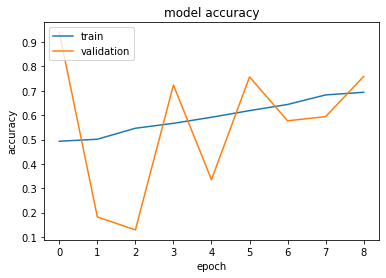

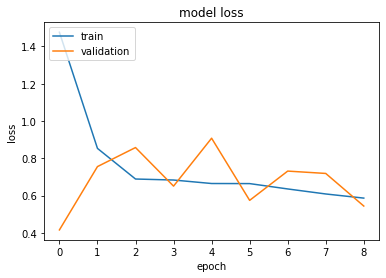

In [110]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [128]:
#load the best model
model.load_weights(file)

In [129]:
y_pred = model.predict_proba(X_train_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_pred)
auc = metrics.auc(fpr,tpr)
print('Train AUC', auc)

y_pred = model.predict(X_train_Array)
print(y_pred.shape)
y_pred1 = y_pred
f_score_macro = metrics.f1_score(y_train, y_pred.round(), average='macro')
print('Train F1 ', f_score_macro)

y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred)
auc = metrics.auc(fpr,tpr)
print('Validation AUC', auc)

y_pred = model.predict(X_valid_Array)
print(y_pred.shape)
y_pred1 = y_pred
f_score_macro = metrics.f1_score(y_valid, y_pred.round(), average='macro')
print('Validation F1 ', f_score_macro)

y_pred = model.predict_proba(X_test_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), y_pred)
auc = metrics.auc(fpr,tpr)
print('Test AUC ', auc)

y_pred = model.predict(X_test_Array)
print(y_pred.shape)
f_score_macro = metrics.f1_score(y_test, y_pred.round(), average='macro')
print('Test F1 ', f_score_macro)

Train AUC 0.8918358999873122
(4198, 1)
Train F1  0.8071509506299726
Validation AUC 0.6960879394784284
(7667, 1)
Validation F1  0.507121874211687
Test AUC  0.6931216563886002
(7667, 1)
Test F1  0.4999998714561643


### Test NN model on test set. 

In [130]:
training = []
validation = []
test = []
metric = []

In [131]:
print('TRAINING')
y_pred = model.predict_proba(X_train_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), y_pred)
auc_tr = metrics.auc(fpr,tpr)
print('Train AUC', auc_tr)
    
y_train_preds = model.predict(X_train_Array)
f1_tr = metrics.f1_score(y_train, y_train_preds.round(), average='macro')
prec_tr = precision_score(y_train, y_train_preds.round(), average='macro') 
recall_tr = recall_score(y_train, y_train_preds.round(), average='macro')
accuracy_tr = accuracy_score(y_train, y_train_preds.round())
print('F1 ', f1_tr)
print('Precision ', prec_tr)
print('Recall ', recall_tr)
print('Accuracy ', accuracy_tr)
print()

print('VALIDATION')
y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred)
auc_val = metrics.auc(fpr,tpr)
print('Validation AUC', auc_val)

y_valid_preds = model.predict(X_valid_Array)
f1_valid = metrics.f1_score(y_valid, y_valid_preds.round(), average='macro')
prec_val = precision_score(y_valid, y_valid_preds.round(), average='macro') 
recall_val = recall_score(y_valid, y_valid_preds.round(), average='macro')
accuracy_val = accuracy_score(y_valid, y_valid_preds.round())
print('F1 ', f1_valid)
print('Precision ', prec_val)
print('Recall ', recall_val)
print('Accuracy ', accuracy_val)
print()

print('TEST')
y_pred = model.predict_proba(X_test_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), y_pred)
auc_test = metrics.auc(fpr,tpr)
print('Test AUC ', auc_test)
y_test_preds = model.predict(X_test_Array)
f1_test = metrics.f1_score(y_test, y_test_preds.round(), average='macro')
prec_test = precision_score(y_test, y_test_preds.round(), average='macro') 
recall_test = recall_score(y_test, y_test_preds.round(), average='macro')
accuracy_test = accuracy_score(y_test, y_test_preds.round())
print('F1 ', f1_test)
print('Precision ', prec_test)
print('Recall ', recall_test)
print('Accuracy ', accuracy_test)


TRAINING
Train AUC 0.8918358999873122
F1  0.8071509506299726
Precision  0.8117399357003076
Recall  0.8077656026679372
Accuracy  0.8077656026679371

VALIDATION
Validation AUC 0.6960879394784284
F1  0.507121874211687
Precision  0.5386836922222868
Recall  0.6442741291934593
Accuracy  0.7114908047476197

TEST
Test AUC  0.6931216563886002
F1  0.4999998714561643
Precision  0.5359172971217571
Recall  0.6382123755199973
Accuracy  0.7022303378113995


In [132]:
metric.append('AUC')
training.append(auc_tr)
validation.append(auc_val)
test.append(auc_test)

metric.append('Accuracy')
training.append(accuracy_tr)
validation.append(accuracy_val)
test.append(accuracy_test)

metric.append('Precision')
training.append(prec_tr)
validation.append(prec_val)
test.append(prec_test)

metric.append('Recall')
training.append(recall_tr)
validation.append(recall_val)
test.append(recall_test)

metric.append('F1')
training.append(f1_tr)
validation.append(f1_valid)
test.append(f1_test)

In [133]:
results_test = pd.DataFrame({'metric': metric, 'Training': training, 
                       'Validation': validation, 'Test': test})
results_test

,metric,Training,Validation,Test
0,AUC,0.891836,0.696088,0.693122
1,Accuracy,0.807766,0.711491,0.702230
2,Precision,0.811740,0.538684,0.535917
3,Recall,0.807766,0.644274,0.638212
4,F1,0.807151,0.507122,0.500000


In [135]:
results_test.to_csv('NN_train_test_results.csv', sep=',', index=False)

### Conclusions
- The best model among Logistic regression models, according to  AUC and F1 evaluation metric, is LogReg with cross-validation. 
- BoW of N-grams do not improve the result. 
- NN performs not the best way in validation step but outperforms LogReg best model almost in all metrics. 
- My models do not beat Longs' ones in AUC but do beat in accuracy, precision and recall. I would say that they are more balanced and robust. 